# Part (d)
For this part a 3 layer convolutional layer is implemented.(2 convolutional layers followed by max pooling) + 1 non-linear layer (256units), followed by softmax.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os

In [2]:
# Need to load the MNist data to work with
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("data/MNIST/", one_hot=True)
# one hot true gives the y labels as vectors with 1's which correspond to the number it is

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


### Data dimenions

In [3]:
im_size = 28
im_flat = im_size**2

# Also have a dimsension of 10 for the one hot vectors.
num_digits = 10
units = 256

### Variables

In [4]:
# Need to define Variables that will be optimized

# The Dimensionality of the weight vector to be able to multiply with 
# x and won't havr
def W(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
    #return tf.Variable(tf.zeros(shape))
    
    
def b(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))
    #return tf.Variable(tf.zeros(length))

## Convolutional layer
A function is used to take the input layer, the number of channels, the size of the filters and the number of filters used. Max pooling is also used. First need to set up the shape and number of filters to be used.

In [5]:
# Need to define the filter size and the number of filters
# want (3,3,16): 16 3x3 filters
filter_size1 = 3
num_filters1 = 16

#second convoultional layer
filter_size2 = 3
num_filters2= 16



In [6]:
def conv_layer(input, num_channels, filter_size,
              num_filters, pooling =True):
    # need to get weights and biases in the correct size as a tesnor
    # which is a 4d tesnor.
    shape=[filter_size,filter_size,num_channels, num_filters]
    
    # get the variables
    weights = W(shape)
    biases = b(num_filters)
    
    # now to create the convolution layer
    convLayer = tf.nn.conv2d(input, filter = weights, strides =[1,1,1,1],
                            padding = 'SAME')
    
    # Add the bias to each filter
    convLayer += biases
    
    if pooling:
        layer = tf.nn.max_pool(convLayer, ksize = [1,2,2,1],
                              strides = [1,2,2,1],
                              padding = 'SAME')
        
    
   
    return layer, weights

# Flatten layer
Need to get the output of the convolution layer back into a 2d tensor to read in for the fully connected layer

In [7]:
def flatten(layer):
    
    shape = layer.get_shape()
    # the number of features= im_height* im_width* num_channels
    features = shape[1:4].num_elements()
    flat_layer = tf.reshape(layer,[-1,features])
    
    # -1 is used lets us leave it arbitrary 
    
    return flat_layer, features
    

## Fully connected layer.
This function takes an input, initialy $\bf{X}$, then the output of then non linear layer. The number of inputs is the flatend pixels, and then 256 units for the second layer. Since we know how many units we want, we can specify that too, initially 128 units, then 10 classes. Since we have a ReLU in the hidden layer and only a linear layer in the second, the ReLU argument allows us to implement an activation if we like. 


In [8]:
def fc_layer(input, num_inputs, num_outputs,use_relu=True):       
    # The previous layer, Num. inputs from prev. layer, Num. outputs.
    # Use ReLU?

    # Create new weights and biases.
    weights = W(shape=[num_inputs, num_outputs])
    biases = b(length=num_outputs)

    # Do the linear layer by simply doing matrix multiplication
    # and adding the bias terms.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

### Placeholders for data

In [9]:
# need placeholders for the inputs to train, x, and the true labels
x = tf.placeholder( tf.float32, shape =[None, im_flat])
# None is used as it the number of images to be used is not yet defined
# possible to pass throught any size data, with 784 features(pixels)

# Create a placeholder for the y labels
y_label = tf.placeholder( tf.float32, shape = [None, num_digits])

# Since y_labels are one hot vectors, get the actual digit label.
y_digit = tf.argmax(y_label, dimension = 1)
# Need to reshape the input x into a 4d tensor to use in the 
# convolutional layer

x_conv_shape = tf.reshape(x, [-1, im_size, im_size, 1])

### First Convolutional layer

In [10]:
layer_conv1, weights_conv1 = \
    conv_layer(input=x_conv_shape,
                   num_channels=1,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                pooling=True)

In [11]:
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 14, 14, 16) dtype=float32>

### Second Convolutional layer

In [12]:
layer_conv2, weights_conv2 = \
    conv_layer(input=layer_conv1,
                   num_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                    pooling=True)

In [13]:
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 7, 7, 16) dtype=float32>

### Flaten for the fully connected layer

In [14]:
flat_layer, features = flatten(layer_conv2)

# Check the size to see the number of features used
print(features)
print(flat_layer)

784
Tensor("Reshape_1:0", shape=(?, 784), dtype=float32)


### Non Linear Layer

In [15]:
non_lin = fc_layer(flat_layer, features,
                  256, use_relu=True)

In [16]:
print(non_lin)

Tensor("Relu_2:0", shape=(?, 256), dtype=float32)


 ### Linear Layer

In [17]:
lin_layer= fc_layer(non_lin,256, num_digits
                    , use_relu=False)

In [18]:
print(lin_layer)

Tensor("add_3:0", shape=(?, 10), dtype=float32)


### Softmax

In [19]:
y_pred = tf.nn.softmax(lin_layer)

In [20]:
y_pred_digit = tf.argmax(y_pred, dimension = 1)

### Cross Entropy Loss.

In [21]:
Xent = tf.nn.softmax_cross_entropy_with_logits(lin_layer, y_label)

In [22]:
cost = tf.reduce_mean(Xent)

### Optimizer object
Use gradient descent to optimize the cost. The stochastic part comes from using randfom batches.

In [23]:
# The object is created to pass the cost function through
# The stocastic process comes from using small batch samples
optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.275).minimize(cost)

In [24]:
correct_prediction = tf.equal(y_pred_digit, y_digit)

In [25]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Save Model

In [26]:
# Need to save the model, weights and biases varibles
saver = tf.train.Saver()

# Suggested Directory to use
save_MDir = 'models/'


#create the directory if it does not exist already
if not os.path.exists(save_MDir):
    os.makedirs(save_MDir)

save_model = os.path.join(save_MDir,'best_accuracyd')    

## Begin Session

In [27]:
sess = tf.Session()

In [28]:
sess.run(tf.global_variables_initializer())

In [29]:
train_batch_size = 100
batch_size = 100

In [31]:
# accuracy using all the training set
def print_acc():
    train_dict = {x: data.train.images, y_label: data.train.labels}
    test_dict = {x: data.test.images, y_label: data.test.labels}
    acc_train = sess.run(accuracy,feed_dict = train_dict)
    acc_test  = sess.run(accuracy,feed_dict = test_dict)
    print("Using all the training set rater than just a batch:\n")
    print("Training Accuracy: {0:.1%} \n".format(acc_train))
    print("Test Accuracy: {0:.1%} \n".format(acc_test))

In [32]:
# accuracy using just the training batch size
def print_acc_batch(x_batch,y_batch):
    # Get the batch images, x, and labels,y.
    #x_batch, y_batch = data.train.next_batch(batch_size)
    #x_batch = data.train.images[0:100,:]
    #y_batch = data.train.labels[0:100,:]
    # need a dictionary which feeds the batches into the 
    # placeholder values
    train_dict = {x: x_batch,y_label: y_batch}
    test_dict = {x: data.test.images, y_label: data.test.labels}
    acc_train = sess.run(accuracy,feed_dict = train_dict)
    acc_test  = sess.run(accuracy,feed_dict = test_dict)
    print("Using the last batch rather than all the training data:\n")
    print("Training Accuracy: {0:.1%} \n".format(acc_train))
    print("Test Accuracy: {0:.1%} \n".format(acc_test))

### Optimizer function

In [33]:
# Counter for total number of iterations performed so far.
total_iterations = 0
feed_dict_test = {x:data.test.images, y_label: data.test.labels}

def optimize_train(num_iterations,print_num):
    total_iterations = 0
    # Ensure we update the global variable rather than a local copy.
    global total_iterations
    
    freq = num_iterations/print_num
    train_acc =[]
    train_loss = []
    test_acc = []
    test_loss =[]
    length = np.linspace(1,num_iterations,print_num)
    start_time = time.time()
    
    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_label: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        sess.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % freq == 0:
            
            # Calculate the accuracy on the training-set.
            acc = sess.run(accuracy, feed_dict=feed_dict_train)
            
            loss_train = sess.run(cost,feed_dict=feed_dict_train)
            train_acc.append(acc)
            train_loss.append(loss_train)
            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))
            accuracy_test = sess.run(accuracy,feed_dict=feed_dict_test)
            loss_test = sess.run(cost,feed_dict=feed_dict_test)
            test_acc.append(accuracy_test)
            test_loss.append(loss_test)
            print("\t\t \t\t Test Accuracy:{1:6.1%}\n".format(1+i, accuracy_test))

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
    return(train_acc,test_acc,length,train_loss,test_loss,x_batch,y_true_batch)        


<ipython-input-33-dfa6c6cbff81>:8: SyntaxWarning: name 'total_iterations' is assigned to before global declaration
  global total_iterations


### 100 iterations

In [35]:
[train_acc10,test_acc10,length10,train_loss10,test_loss10,x_batch,y_batch] =optimize_train(100,print_num = 20)
print_acc()

Optimization Iteration:      1, Training Accuracy:  27.0%
		 		 Test Accuracy: 18.5%

Optimization Iteration:      6, Training Accuracy:  28.0%
		 		 Test Accuracy: 20.2%

Optimization Iteration:     11, Training Accuracy:  18.0%
		 		 Test Accuracy: 19.1%

Optimization Iteration:     16, Training Accuracy:  54.0%
		 		 Test Accuracy: 39.3%

Optimization Iteration:     21, Training Accuracy:  62.0%
		 		 Test Accuracy: 63.9%

Optimization Iteration:     26, Training Accuracy:  57.0%
		 		 Test Accuracy: 51.3%

Optimization Iteration:     31, Training Accuracy:  56.0%
		 		 Test Accuracy: 49.9%

Optimization Iteration:     36, Training Accuracy:  63.0%
		 		 Test Accuracy: 52.4%

Optimization Iteration:     41, Training Accuracy:  76.0%
		 		 Test Accuracy: 68.1%

Optimization Iteration:     46, Training Accuracy:  67.0%
		 		 Test Accuracy: 62.5%

Optimization Iteration:     51, Training Accuracy:  84.0%
		 		 Test Accuracy: 76.0%

Optimization Iteration:     56, Training Accuracy:  86

In [36]:
print_acc_batch(x_batch,y_batch)

Using the last batch rather than all the training data:

Training Accuracy: 97.0% 

Test Accuracy: 91.8% 



### Plot accuracy

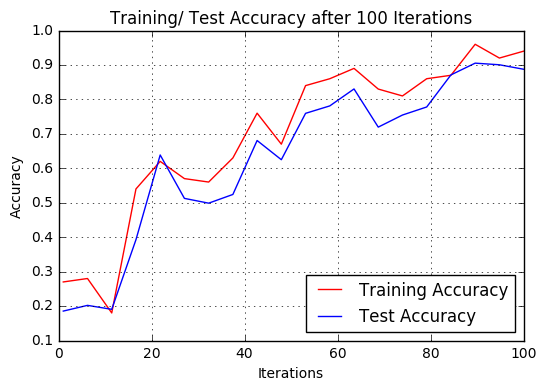

In [49]:
plt.title('Training/ Test Accuracy after 100 Iterations')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')

plt.grid(True)

plt.plot(length10,train_acc10,color="red", label="Training Accuracy")
plt.plot(length10,test_acc10,color="blue", label="Test Accuracy")

plt.legend( loc='lower right')
plt.savefig("Accuracy_10d.png", bbox_inches='tight')
plt.show()

### Plot Loss

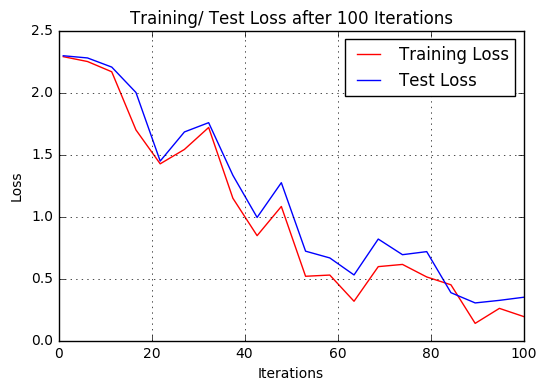

In [50]:
plt.title('Training/ Test Loss after 100 Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')

plt.grid(True)
plt.plot(length10,train_loss10,color="red", label="Training Loss")
plt.plot(length10,test_loss10,color="blue", label="Test Loss")

plt.legend( loc='upper right')
plt.savefig("Loss_10d.png", bbox_inches='tight')
plt.show()

In [39]:
sess.run(tf.global_variables_initializer())

### 10,000 iterations

In [42]:
[train_acc,test_acc,length,train_loss,test_loss,x_batch2,y_batch2] = optimize_train(10000,print_num = 50)
print_acc()

Optimization Iteration:      1, Training Accuracy:  13.0%
		 		 Test Accuracy: 11.4%

Optimization Iteration:    201, Training Accuracy:  99.0%
		 		 Test Accuracy: 94.8%

Optimization Iteration:    401, Training Accuracy: 100.0%
		 		 Test Accuracy: 96.4%

Optimization Iteration:    601, Training Accuracy:  99.0%
		 		 Test Accuracy: 97.0%

Optimization Iteration:    801, Training Accuracy: 100.0%
		 		 Test Accuracy: 98.0%

Optimization Iteration:   1001, Training Accuracy:  99.0%
		 		 Test Accuracy: 98.2%

Optimization Iteration:   1201, Training Accuracy: 100.0%
		 		 Test Accuracy: 98.3%

Optimization Iteration:   1401, Training Accuracy: 100.0%
		 		 Test Accuracy: 98.4%

Optimization Iteration:   1601, Training Accuracy: 100.0%
		 		 Test Accuracy: 98.5%

Optimization Iteration:   1801, Training Accuracy: 100.0%
		 		 Test Accuracy: 98.7%

Optimization Iteration:   2001, Training Accuracy: 100.0%
		 		 Test Accuracy: 98.7%

Optimization Iteration:   2201, Training Accuracy: 100

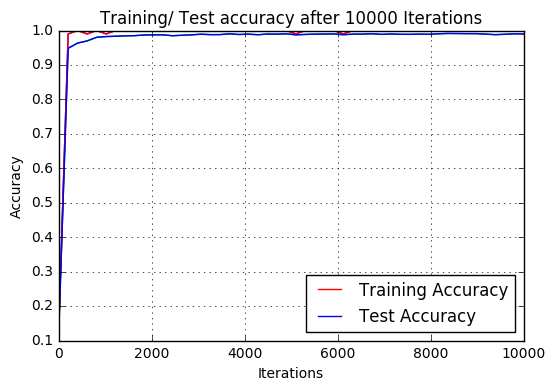

In [43]:
plt.title('Training/ Test accuracy after 10000 Iterations')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')

plt.grid(True)
plt.plot(length,train_acc)
plt.plot(length,test_acc)
plt.plot(length,train_acc,color="red", label="Training Accuracy")
fig = plt.plot(length,test_acc,color="blue", label="Test Accuracy")


plt.legend( loc='lower right')
plt.savefig("Accuracy_10000d.png", bbox_inches='tight')
plt.show()


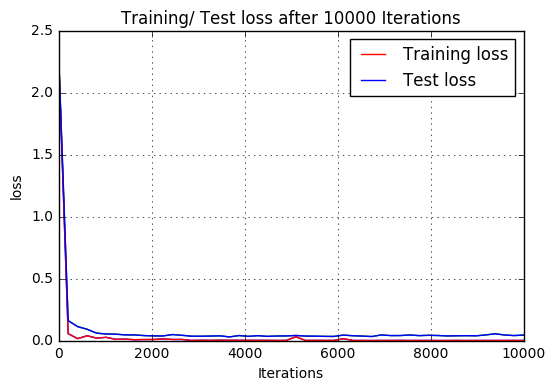

In [44]:
plt.title('Training/ Test loss after 10000 Iterations')
plt.xlabel('Iterations')
plt.ylabel('loss')

plt.grid(True)
plt.plot(length,train_loss)
plt.plot(length,test_loss)
plt.plot(length,train_loss,color="red", label="Training loss")
plt.plot(length,test_loss,color="blue", label="Test loss")
plt.legend( loc='upper right')
plt.savefig("Loss_10000d.png", bbox_inches='tight')
plt.show()

[[ 977    1    0    0    0    0    1    1    0    0]
 [   0 1129    1    0    0    1    1    1    2    0]
 [   2    2 1021    0    1    0    0    5    1    0]
 [   1    0    1 1002    0    1    0    0    4    1]
 [   1    0    0    0  969    0    3    2    0    7]
 [   3    0    0   11    0  870    7    0    1    0]
 [   4    3    0    0    1    2  947    0    1    0]
 [   0    0    3    2    0    0    0 1020    1    2]
 [   5    0    3    2    0    3    1    1  956    3]
 [   0    0    0    0    5    0    0    2    2 1000]]


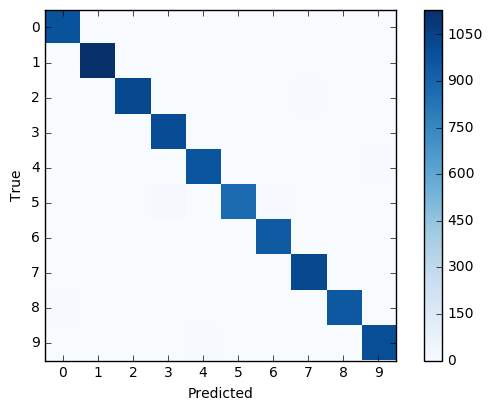

In [45]:
#defined the actual digits of labels again
y_true = data.test.labels
y_true_digit = np.argmax(y_true,axis = 1)

feed_dict_test = {x: data.test.images,
                           y_label: data.test.labels}
# find the predicted labels
y_pred = sess.run(y_pred_digit, feed_dict = feed_dict_test)

# get the confusion matrix
conf_mat = confusion_matrix( y_true_digit,
                             y_pred)
print(conf_mat)
plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.tight_layout()
plt.colorbar()
tick_marks = np.arange(num_digits)
plt.xticks(tick_marks, range(num_digits))
plt.yticks(tick_marks, range(num_digits))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig("CM_10000d.png", bbox_inches='tight')
plt.show()

In [46]:
saver.save(sess= sess, save_path = save_model)

'models/best_accuracyd'

In [47]:
sess.close()

In [48]:
save_MDir = 'models/'
save_model = os.path.join(save_MDir,'best_accuracyd')    
saver2restore = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver2restore.restore(sess = sess, save_path= save_model)
    print("Restored values:\n")

    print('\n')
    print_acc()

Restored values:



Using all the training set rater than just a batch:

Training Accuracy: 99.9% 

Test Accuracy: 98.9% 



# Run the saved model notebook to check if the accuracy is the same as in the report.